Sets up LB parameters and simulation geometry.
This is just a box with an inlet on one side, and an outlet on the other. The initial velocity is non-zero.

In [1]:
using LatBo

mmHg = 133.3223684211
Npoints = 60, 60
δt, δx = 5e-4, 1e-3
μ₀ = 0.01sqrt(1./3.) * δt / δx
# holds CFD kernels and parameters
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, p₀=80.0 * mmHg, μ₀ = ones(2)μ₀)
# defines where the fluid is flowing
Playground.initialize(sim.playground) do i, j
    if j == 1
        return Playground.INLET
    elseif j == Npoints[2]
        return Playground.OUTLET
    elseif j == 1 || j == Npoints[2] || i == 1 || i == Npoints[1]
        return Playground.SOLID
    else
        return Playground.FLUID
    end
end
nothing

The different kernels for the different sites have a given set of default values. They can be investigated and/or modified by accessing the dictionary `sim.kernels`. Streamers are located inside each kernel.

In [2]:
sim.kernels[Playground.FLUID].streamers

Dict{UInt8,LatBo.LB.Streaming} with 4 entries:
  0x04 => LatBo.LB.NashZeroOrderPressure{Float64}([0.0,1.0],8.99934)
  0x02 => LatBo.LB.FluidStreaming()
  0x03 => LatBo.LB.HalfWayBounceBack()
  0x05 => LatBo.LB.NashZeroOrderPressure{Float64}([0.0,1.0],8.99934)

Does actual computation, while keeping trac of total kinetic energy

In [3]:
kinetic = Float64[]
run!(sim, nsteps=120) do
    ν = velocity(sim)
    valid = !isnan(ν)
    push!(kinetic, 0.5sum(momentum(sim)[valid] .* ν[valid]))
end

Here, we use `Gadfly` for plotting different quantities. This might require users to run `Pkg.add("Gadfly")`. Note that the playground is not plotted, which makes it a bit difficult to figure out where inlets and outlets are located. Pull-requests welcomed.

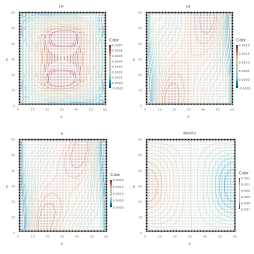

In [4]:
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))
using Gadfly
width=5inch
set_default_plot_size(2width, 2width * float(Npoints[2])/float(Npoints[1]))

x = [gridcoords(sim.indexing, i)[1] for i = 1:length(sim.playground)]
y = [gridcoords(sim.indexing, i)[2] for i = 1:length(sim.playground)]
vstack(
  hstack(
    plot(:μx, sim, Theme(default_point_size=1pt, highlight_width=0pt)),
    plot(:μy, sim, Theme(default_point_size=1pt, highlight_width=0pt))
  ),
  hstack(
    plot(:μ, sim, Theme(default_point_size=1pt, highlight_width=0pt)),
    plot(:density, sim, Theme(default_point_size=1pt, highlight_width=0pt))
  )
)

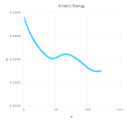

In [5]:
set_default_plot_size(width, width * float(Npoints[2])/float(Npoints[1]))
plot(x=collect(1:length(kinetic)), y=kinetic, Geom.line, Geom.point, Guide.Title("Kinetic Energy"))